# Importing Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import clear_output

import numpy as np
import pandas as pd
import yaml
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.kde import gaussian_kde

import plotly.express as px
import plotly.io as pio

from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.palettes import all_palettes
from bokeh.models import HoverTool, LabelSet, Legend, ColumnDataSource, LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar, GeoJSONDataSource
from bokeh.embed import components
from bokeh.resources import CDN

from bokeh.models.transforms import LinearInterpolator
output_notebook()

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows


Loading BokehJS ...

C:\Users\43xqu\AppData\Local\Temp\ipykernel_15900\2862266035.py:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


60

# Loading dataset

In [2]:
df = pd.read_csv('../data/5years.csv')

In [3]:
# Add date
date = df['MO'].astype('string') + '-' + df['DY'].astype('string') + '-' + df['YEAR'].astype('string')
date = pd.to_datetime(date, format='%m-%d-%Y')
df.insert(loc=0, column='DATE', value=date)

# Add quarter
def mo_to_qua(mo):
    if mo <= 3:
        return 1
    elif mo > 3 and mo <= 6:
        return 2
    elif mo > 6 and mo <= 9:
        return 3
    else:
        return 4

quarter = df['MO'].map(mo_to_qua)
df.insert(loc=1, column='QUARTER', value=quarter)

# Ploting

In [198]:
cols = ['Temperature', 'Relative_Humidity', 'Specific_Humidity', 'Precipitation', 'Pressure', 'Wind_Speed', 'Wind_Direction']

### 1. Distribution

<AxesSubplot: xlabel='Temperature', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Temperature')]

<AxesSubplot: xlabel='Relative_Humidity', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Relative_Humidity')]

<AxesSubplot: xlabel='Specific_Humidity', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Specific_Humidity')]

<AxesSubplot: xlabel='Precipitation', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Precipitation')]

<AxesSubplot: xlabel='Pressure', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Pressure')]

<AxesSubplot: xlabel='Wind_Speed', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Wind_Speed')]

<AxesSubplot: xlabel='Wind_Direction', ylabel='Count'>

[Text(0.5, 1.0, 'Phân phối của cột : Wind_Direction')]

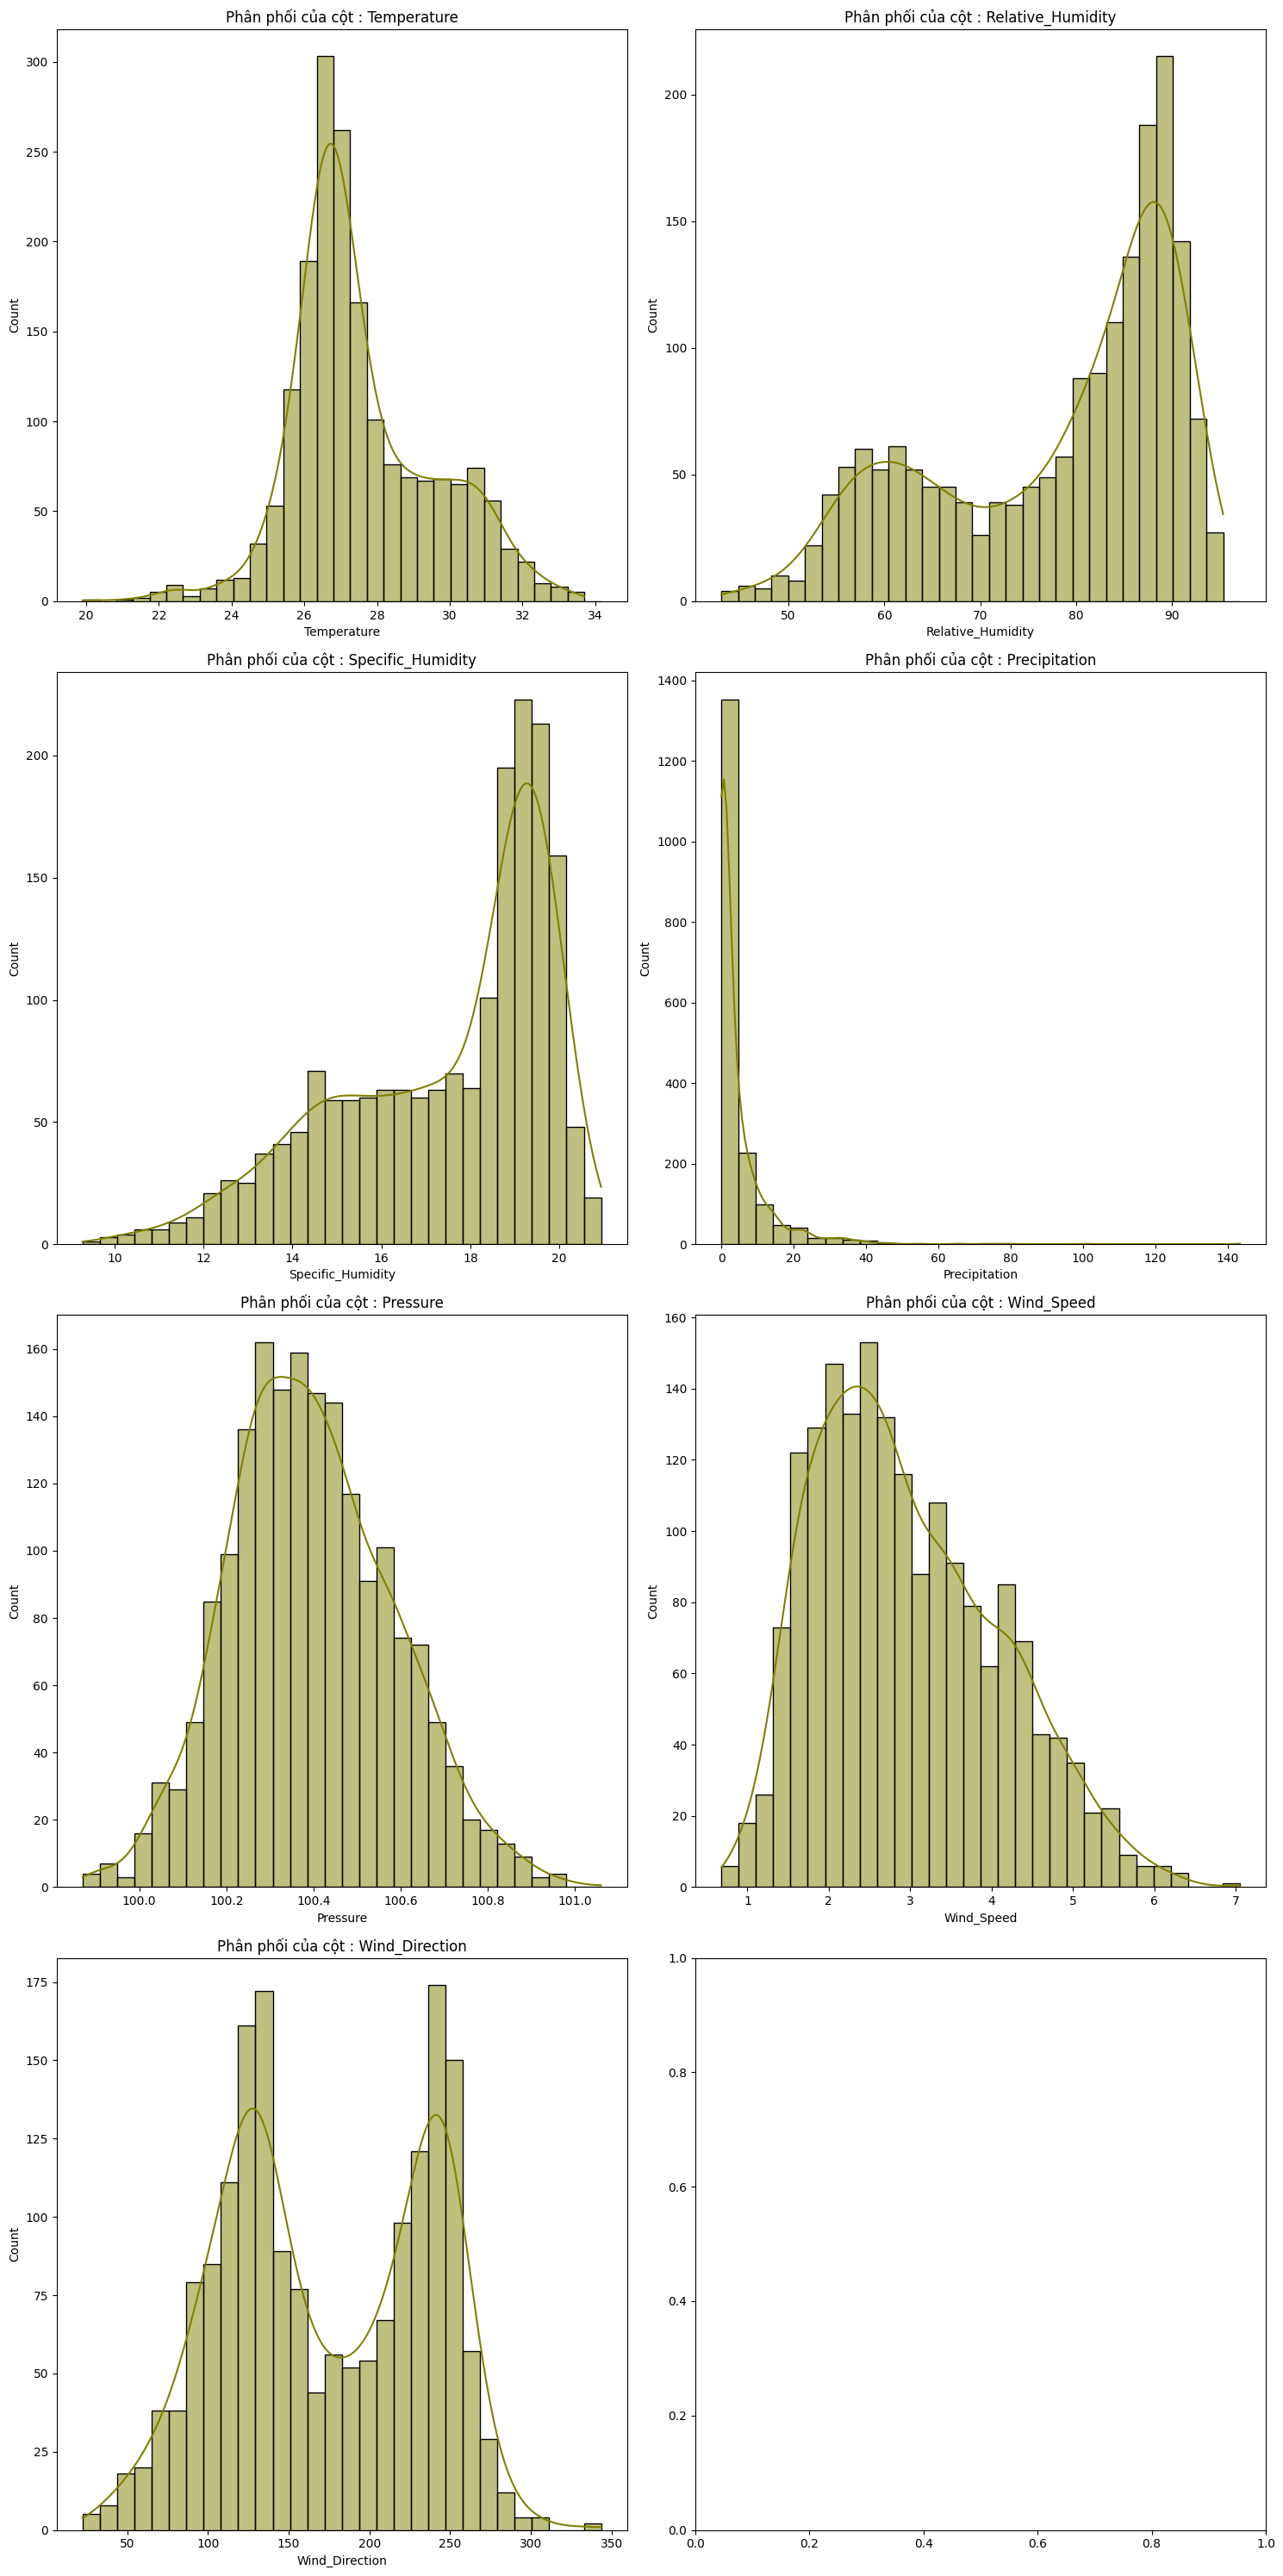

In [199]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30), sharex=False, sharey=False)
axes = axes.ravel() # Index for 1D

for col, ax in zip(cols, axes):
    binwidth = (df[col].max() - df[col].min()) / 30
    sns.histplot(data=df, x=col, binwidth=binwidth, kde=True, color="olive", ax=ax)
    ax.set(title=f'Phân phối của cột : {col}')
    
fig.tight_layout()
plt.show()

__Nhận xét: `Temperature`, `Pressure`, `Wind_Speed` và `pm25` có phân phối gần dạng chuẩn nhất__

In [32]:
def distribution_plot(col):
    hist, edges = np.histogram(df[col], density=True, bins=50)

    p = figure(
        height=750,
        width=750,
        x_axis_label=col, 
        y_axis_label='Mật độ (Density)',
        title='Phân phối của thuộc tính ' + col,
        toolbar_location='below',
        tools='save, pan, box_zoom, wheel_zoom, reset'
    )

    p.quad(
        bottom=0, top=hist, left=edges[:-1], right=edges[1:],
        line_color="white", fill_color='red', fill_alpha=0.75,
        hover_fill_alpha=1.0, hover_fill_color='navy'
    )

    from scipy.stats.kde import gaussian_kde
    pdf = gaussian_kde(df[col])
    x = np.linspace(df[col].min(), df[col].max(), 1000)
    p.line(
        x='top', y='right',
        source=ColumnDataSource(
            pd.DataFrame({
                'top': x,
                'right': pdf(x)
            })
        ),
        line_width=5
    )

    # Add tools
    p.add_tools(
        HoverTool(
            tooltips=[
                ('Mật độ (Density): ', '@top'),
                ('Mức độ ' + col + ': ', '@right')
            ],
            mode='mouse'
        )
    )
    
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    # Title
    p.title_location = "above"
    p.title.text_font_size = "25px"
    p.title.align = "center"
    p.title.background_fill_color = None
    p.title.text_color = "black"

    show(p)

distribution_plot('Temperature')

C:\Users\43xqu\AppData\Local\Temp\ipykernel_15900\3668894542.py:20: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


### 2. Correlation & Heatmap

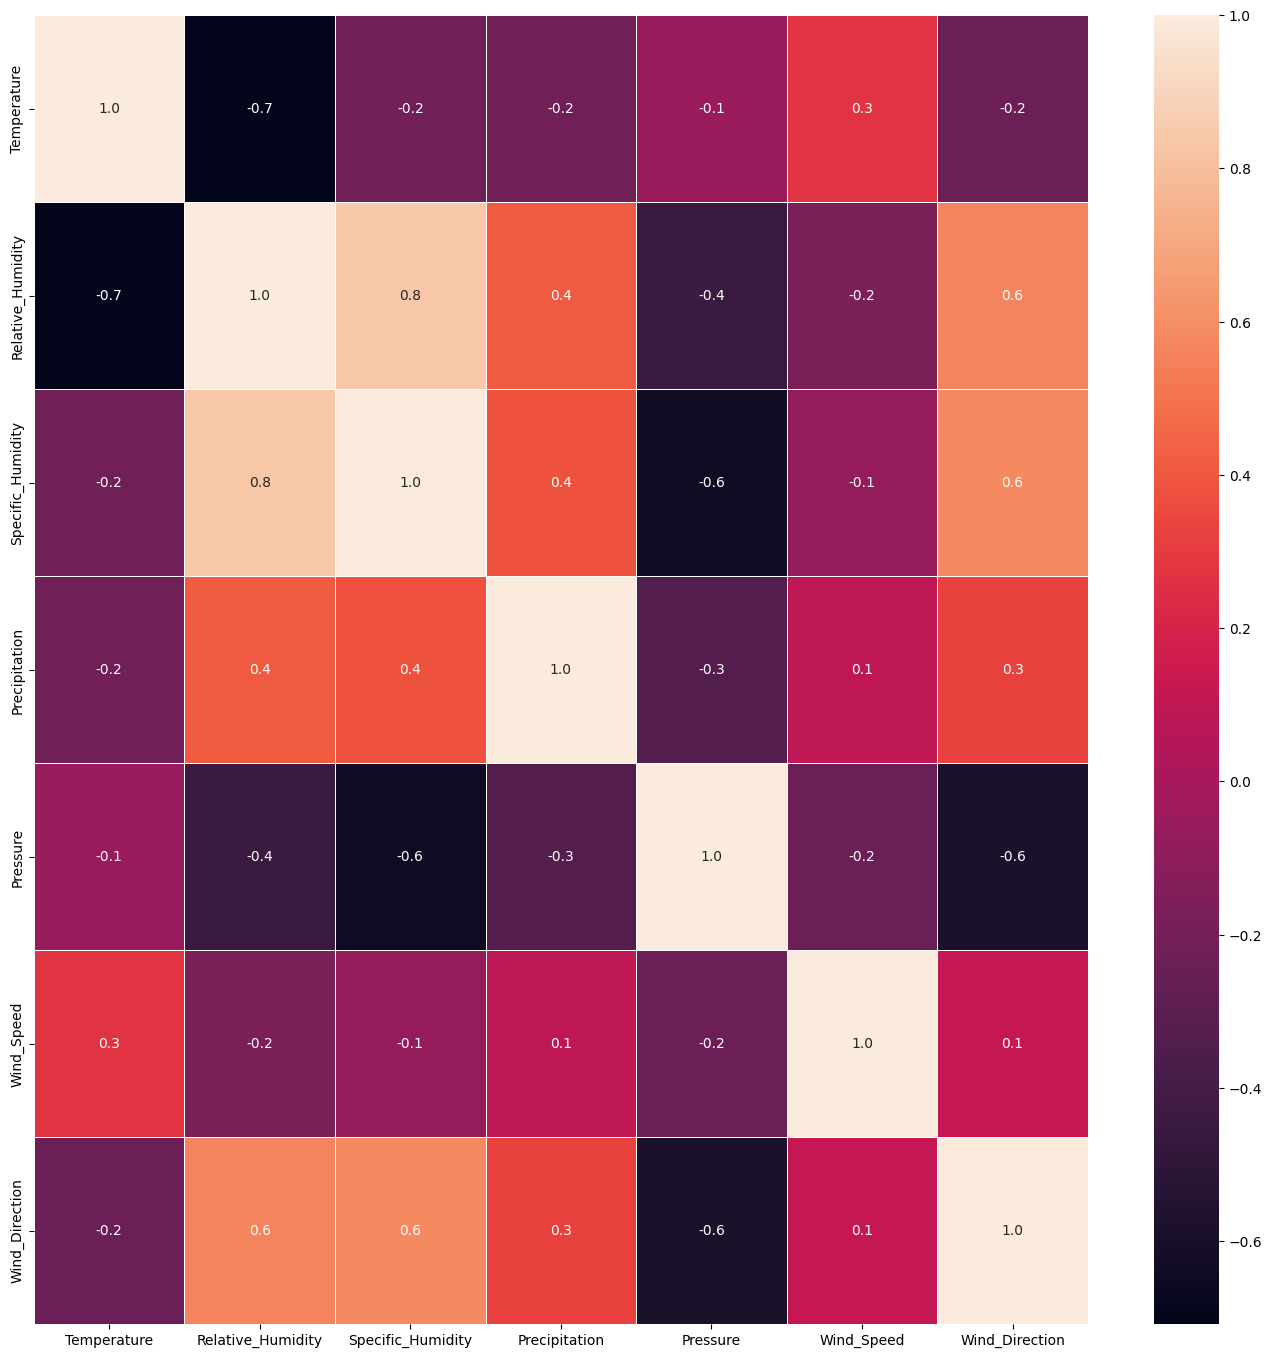

In [201]:
corr = df[cols].corr()
fig, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.show();

__Nhận xét độ tương quan với thuộc tính `pm25`:__
* Tương đối thấp.
* `Wind_Speed` là mạnh nhất bằng `0.5`.

### 3. Features per `MONTH` & `YEAR`
* Các features theo MO
* Các features theo YEAR

In [202]:
def boxplot_chart(category, col):

    data = df[[category, col]]
    x_range = [str(x) for x in df[category].unique()]

    # find the quartiles and IQR for each category
    groups = data.groupby(category)
    q1 = groups.quantile(q=0.25)
    q2 = groups.quantile(q=0.5)
    q3 = groups.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    # find the outliers for each category
    def outliers(group):
        cat = group.name
        return group[
            (group[col] > upper.loc[cat][col]) |
            (group[col] < lower.loc[cat][col])
        ][col]
    out = groups.apply(outliers).dropna()

    # prepare outlier data for plotting, we need coordinates for every outlier.
    if not out.empty:
        outx = list(out.index.get_level_values(0))
        outy = list(out.values)

    p = figure(
        x_range=x_range,
        height=750,
        width=750,
        x_axis_label=category, 
        y_axis_label=col,
        title='Boxplot của thuộc tính ' + col + ' theo ' + category,
        toolbar_location='below',
        tools='save, pan, box_zoom, wheel_zoom, reset'
    )

    # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
    qmin = groups.quantile(q=0.00)
    qmax = groups.quantile(q=1.00)
    upper[col] = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,col]),upper[col])]
    lower[col] = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,col]),lower[col])]

    # stems
    p.segment(x_range, upper[col], x_range, q3[col], line_color="black")
    p.segment(x_range, lower[col], x_range, q1[col], line_color="black")

    # boxes
    p.vbar(x_range, 0.7, q2[col], q3[col], fill_color="#E08E79", line_color="black")
    p.vbar(x_range, 0.7, q1[col], q2[col], fill_color="#3B8686", line_color="black")

    # whiskers (almost-0 height rects simpler than segments)
    p.rect(x_range, lower[col], 0.2, 0.01, line_color="black")
    p.rect(x_range, upper[col], 0.2, 0.01, line_color="black")

    # outliers
    if not out.empty:
        p.circle(
            list(np.array(outx) - 0.5),
            outy,
            size=6,
            color="#F38630",
            fill_alpha=0.6
        )

    # Add tools
    p.add_tools(
        HoverTool(
            tooltips=[
                (col, '@bottom'),
                (category, '@x')
            ],
            mode='mouse'
        )
    )

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = "white"
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size="16px"
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    # Title
    p.title_location = "above"
    p.title.text_font_size = "25px"
    p.title.align = "center"
    p.title.background_fill_color = None
    p.title.text_color = "black"

    show(p)

boxplot_chart('MO', 'Temperature')

In [203]:
def boxplot_chart(col):

    data = df[col]
    hist, edges = np.histogram(df[col], density=True, bins=50)

    p = figure(
        height=750,
        width=750,
        x_axis_label=col, 
        y_axis_label='Mật độ (Density)',
        title='Phân phối của thuộc tính ' + col,
        toolbar_location='below',
        tools='save, pan, box_zoom, wheel_zoom, reset'
    )

    p.quad(
        bottom=0, top=hist, left=edges[:-1], right=edges[1:],
        line_color="white", fill_color='red', fill_alpha=0.75,
        hover_fill_alpha=1.0, hover_fill_color='navy'
    )

    # Add tools
    p.add_tools(
        HoverTool(
            tooltips=[
                ('Mật độ (Density): ', '@top'),
                ('Mức độ ' + col + ': ', '@right')
            ],
            mode='mouse'
        )
    )
    
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    # Title
    p.title_location = "above"
    p.title.text_font_size = "25px"
    p.title.align = "center"
    p.title.background_fill_color = None
    p.title.text_color = "black"

    show(p)
distribution_plot('Temperature')

__Per Months__

<AxesSubplot: xlabel='MO', ylabel='Temperature'>

[Text(0.5, 1.0, 'Temperature theo Tháng')]

<AxesSubplot: xlabel='MO', ylabel='Relative_Humidity'>

[Text(0.5, 1.0, 'Relative_Humidity theo Tháng')]

<AxesSubplot: xlabel='MO', ylabel='Specific_Humidity'>

[Text(0.5, 1.0, 'Specific_Humidity theo Tháng')]

<AxesSubplot: xlabel='MO', ylabel='Precipitation'>

[Text(0.5, 1.0, 'Precipitation theo Tháng')]

<AxesSubplot: xlabel='MO', ylabel='Pressure'>

[Text(0.5, 1.0, 'Pressure theo Tháng')]

<AxesSubplot: xlabel='MO', ylabel='Wind_Speed'>

[Text(0.5, 1.0, 'Wind_Speed theo Tháng')]

<AxesSubplot: xlabel='MO', ylabel='Wind_Direction'>

[Text(0.5, 1.0, 'Wind_Direction theo Tháng')]

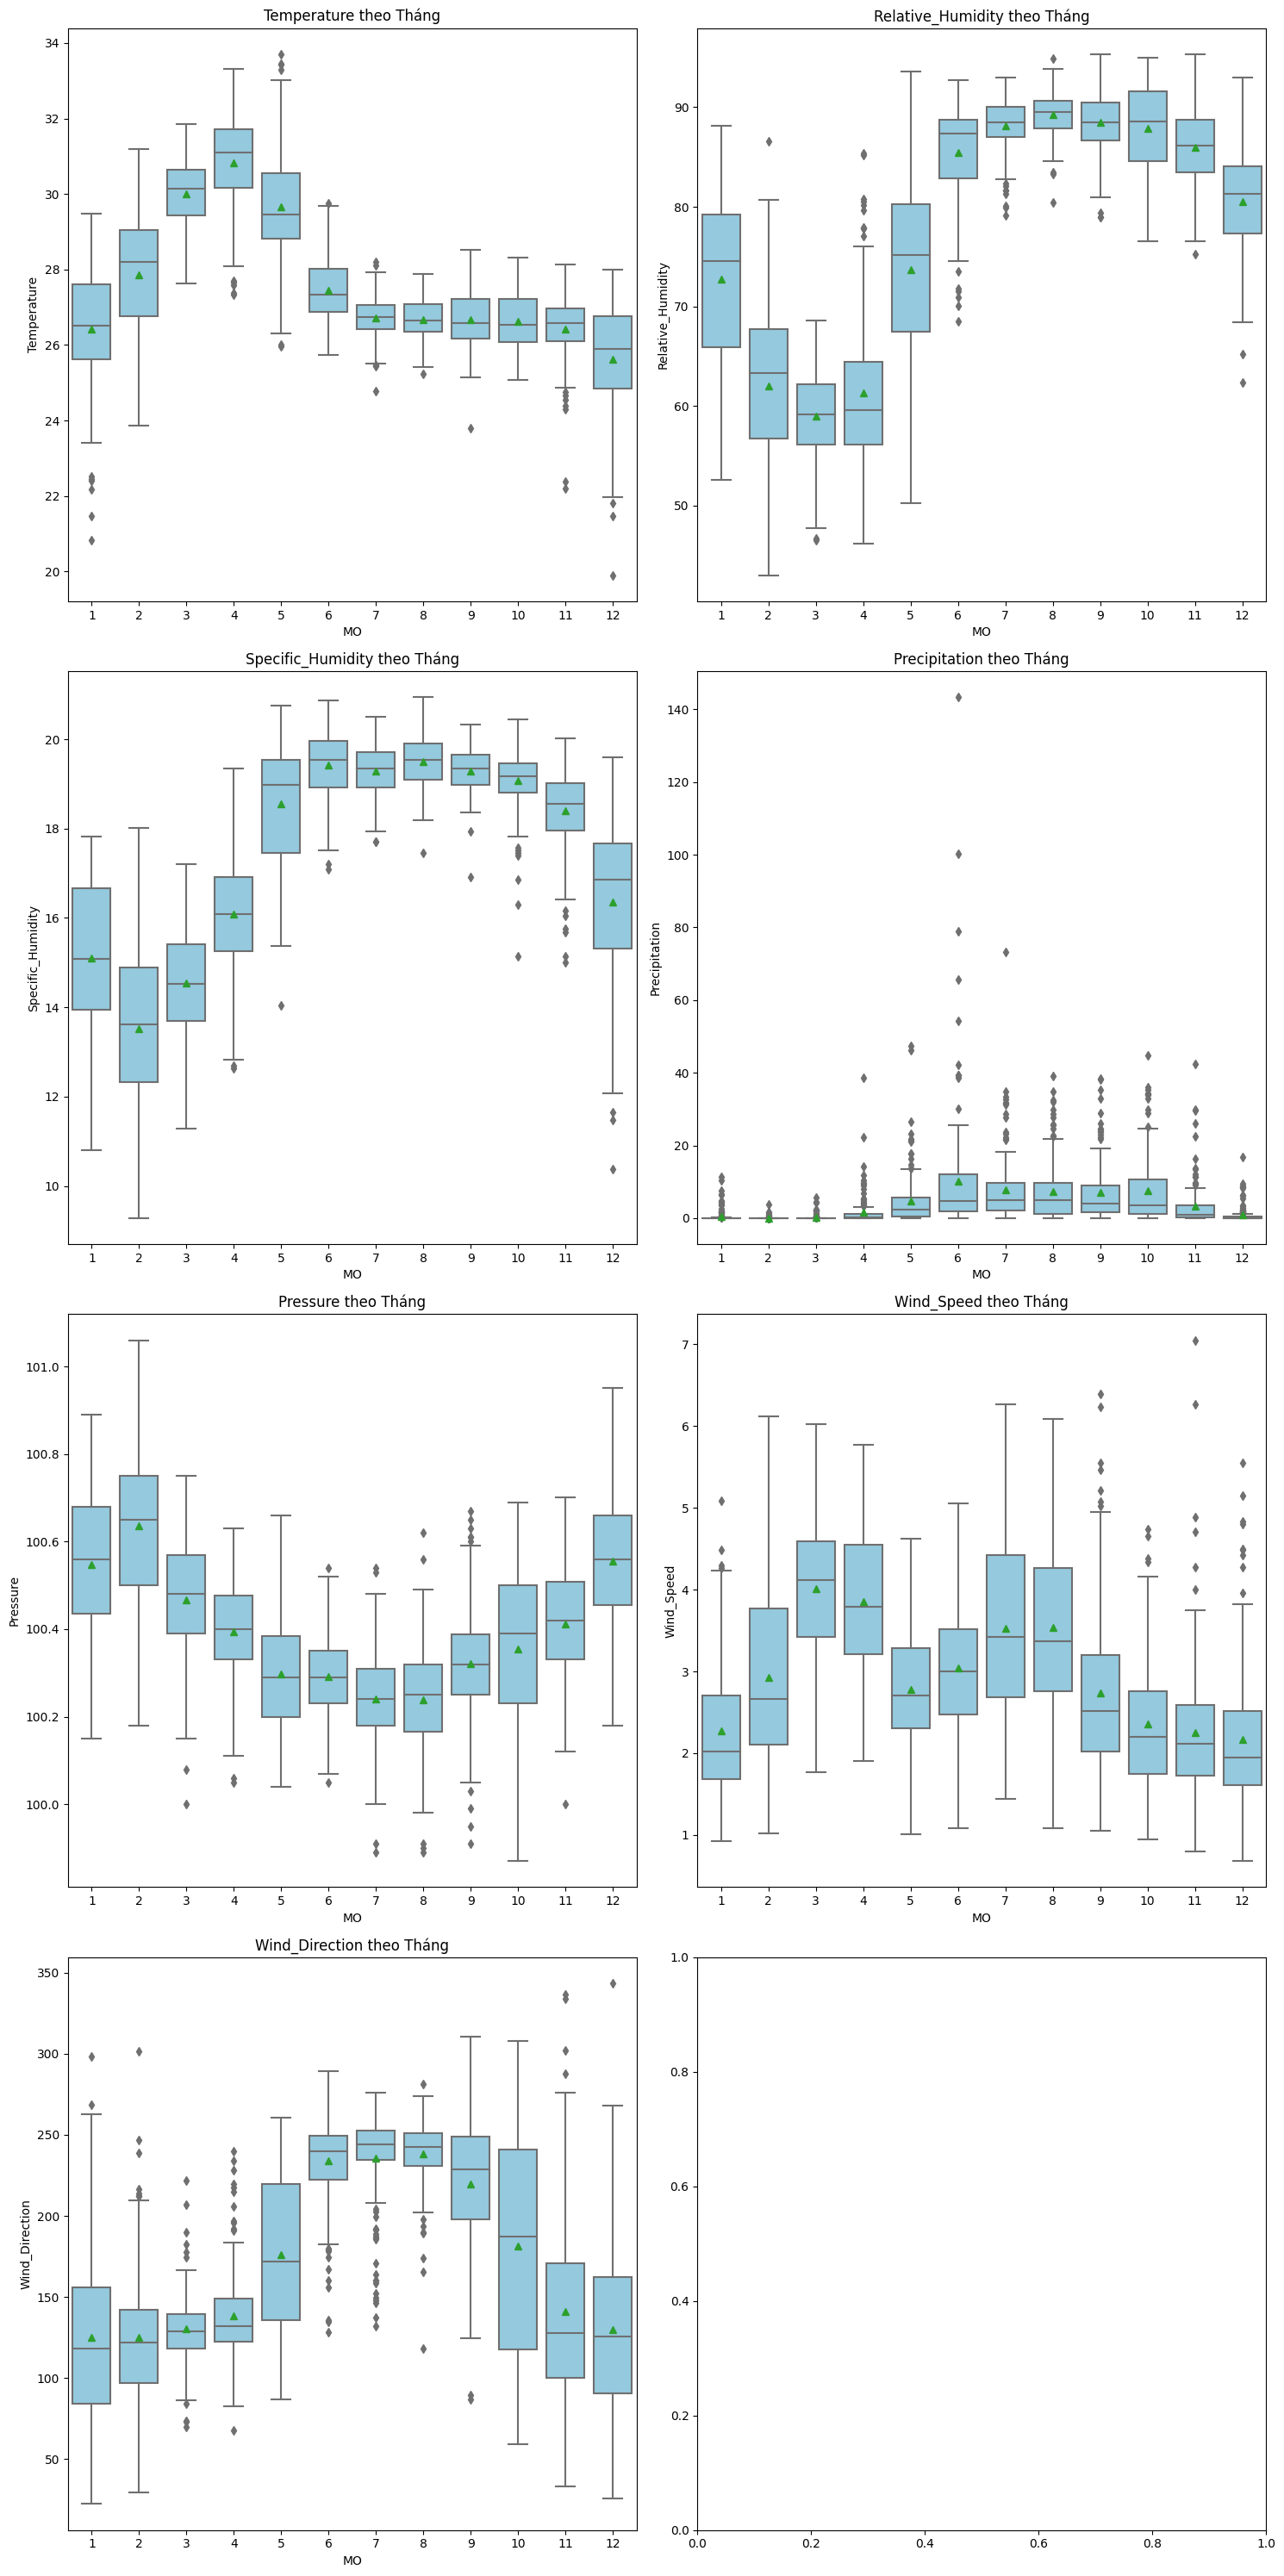

In [204]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30), sharex=False, sharey=False)
axes = axes.ravel() # Index for 1D

for col, ax in zip(cols, axes):
    sns.boxplot(data=df, x='MO', y=col, showmeans=True, color="skyblue", ax=ax)
    ax.set(title=f'{col} theo Tháng')
    
fig.tight_layout()
plt.show()

__Per Year__

<AxesSubplot: xlabel='YEAR', ylabel='Temperature'>

[Text(0.5, 1.0, 'Temperature theo Tháng')]

<AxesSubplot: xlabel='YEAR', ylabel='Relative_Humidity'>

[Text(0.5, 1.0, 'Relative_Humidity theo Tháng')]

<AxesSubplot: xlabel='YEAR', ylabel='Specific_Humidity'>

[Text(0.5, 1.0, 'Specific_Humidity theo Tháng')]

<AxesSubplot: xlabel='YEAR', ylabel='Precipitation'>

[Text(0.5, 1.0, 'Precipitation theo Tháng')]

<AxesSubplot: xlabel='YEAR', ylabel='Pressure'>

[Text(0.5, 1.0, 'Pressure theo Tháng')]

<AxesSubplot: xlabel='YEAR', ylabel='Wind_Speed'>

[Text(0.5, 1.0, 'Wind_Speed theo Tháng')]

<AxesSubplot: xlabel='YEAR', ylabel='Wind_Direction'>

[Text(0.5, 1.0, 'Wind_Direction theo Tháng')]

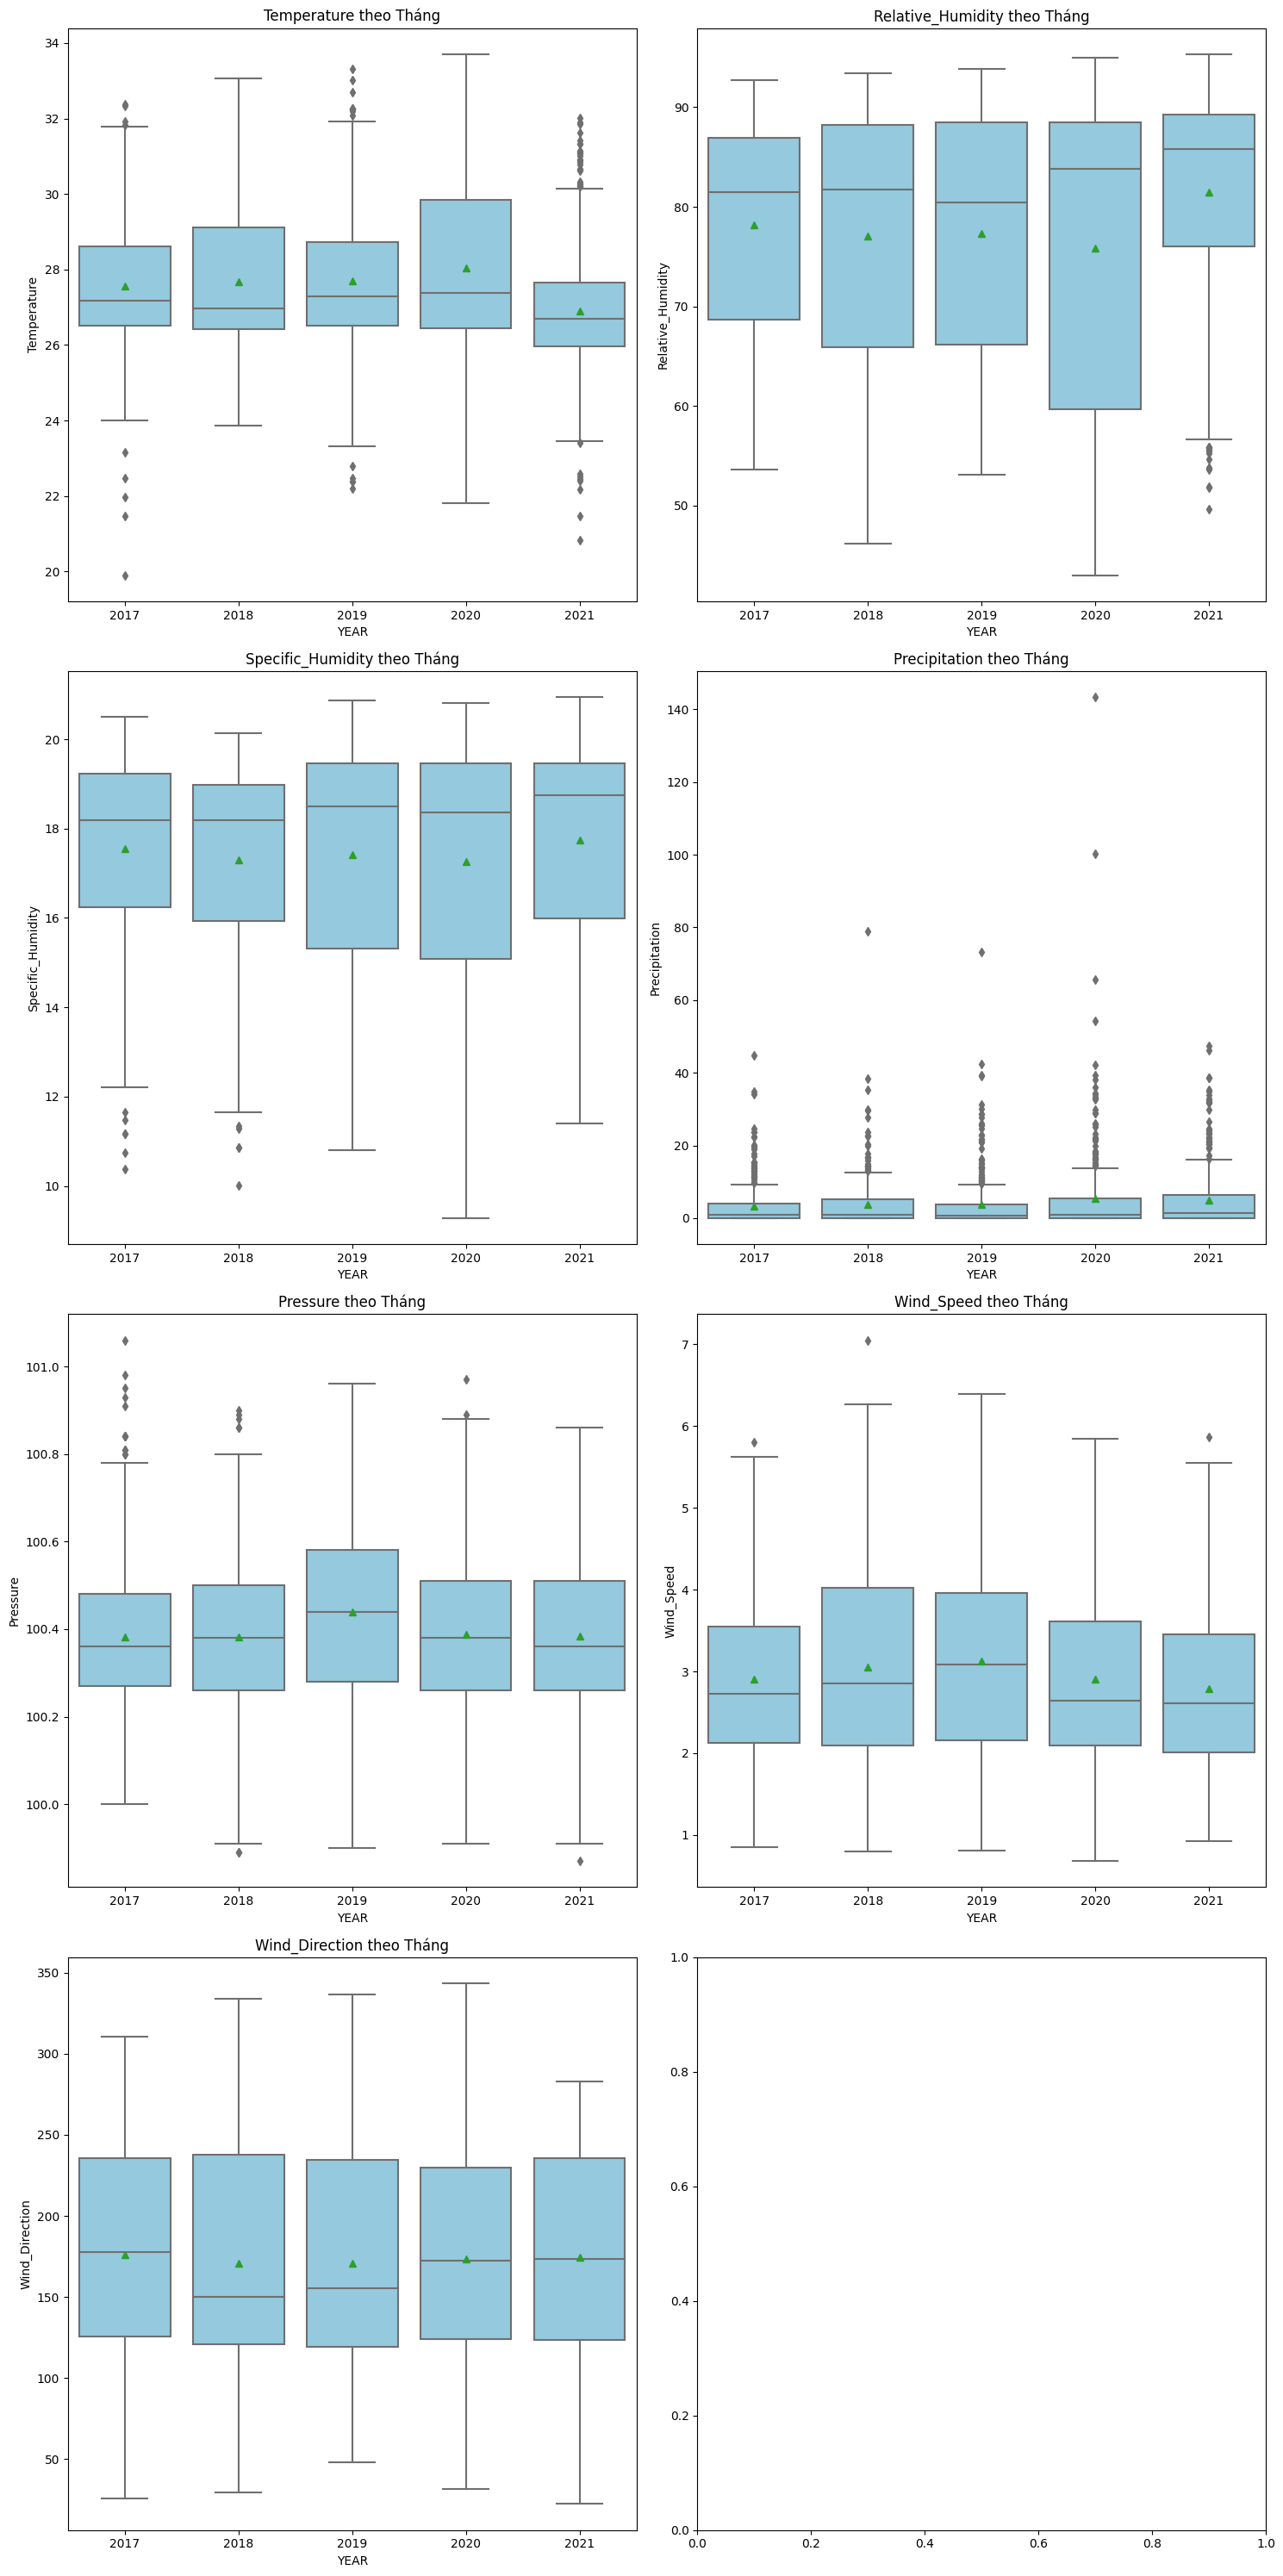

In [205]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30), sharex=False, sharey=False)
axes = axes.ravel() # Index for 1D

for col, ax in zip(cols, axes):
    sns.boxplot(data=df, x='YEAR', y=col, showmeans=True, color="skyblue", ax=ax)
    ax.set(title=f'{col} theo Tháng')
    
fig.tight_layout()
plt.show()

### 3. Regression Plot với `Temperature`

TypeError: 'NoneType' object is not iterable

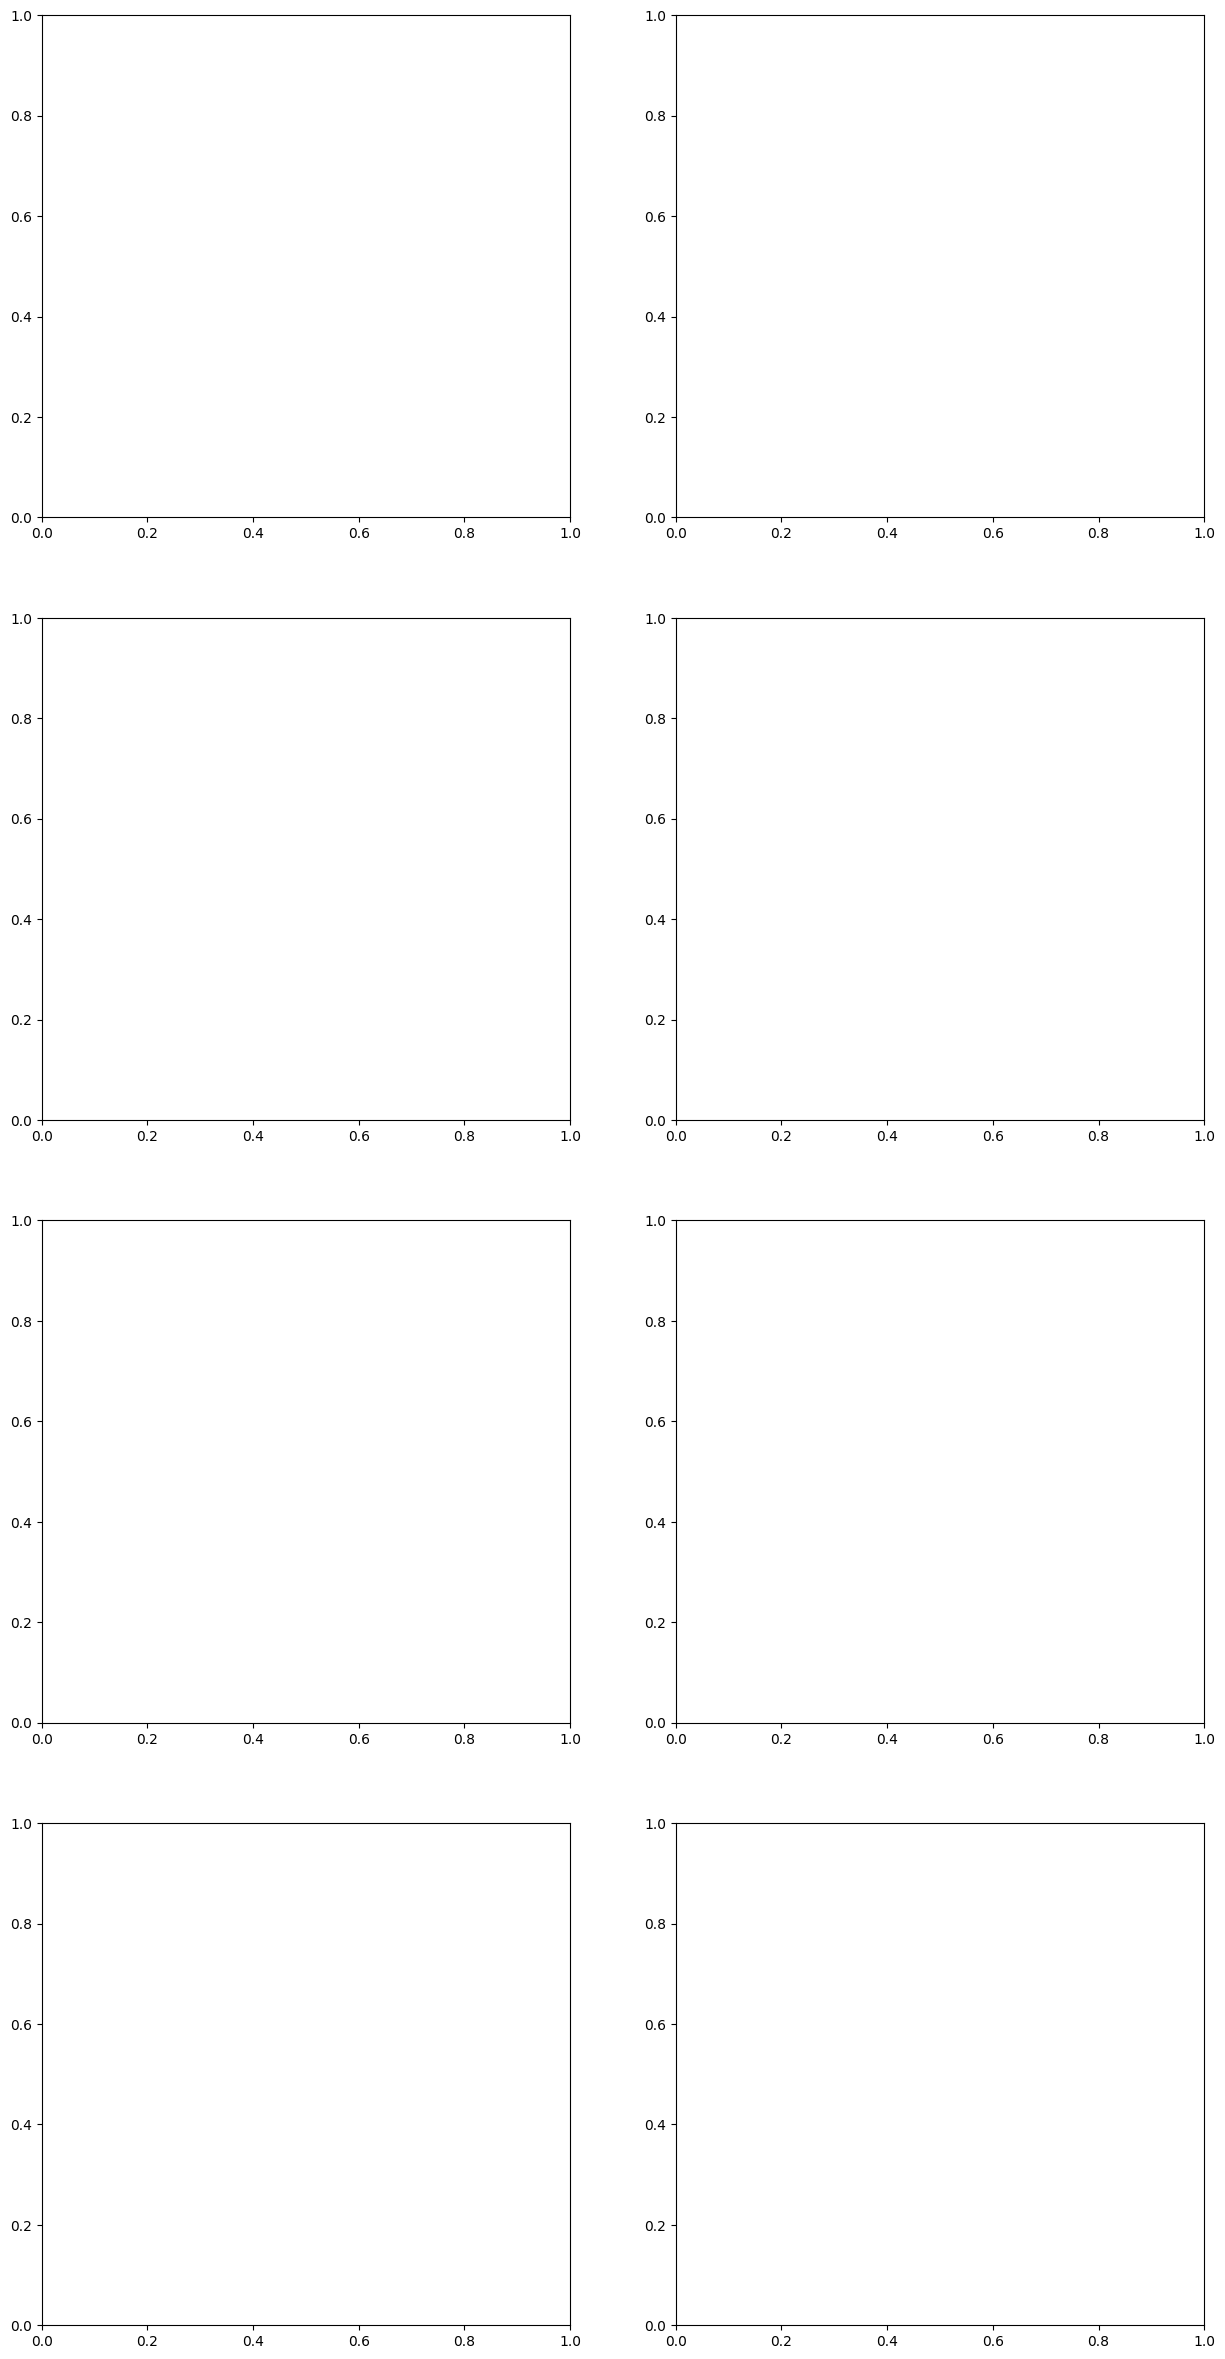

In [206]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30), sharex=False, sharey=False)
axes = axes.ravel() # Index for 1D
new_cols = cols
new_cols = new_cols.remove('Temperature')

for col, ax in zip(new_cols, axes):
    sns.regplot(data=df, x=col, y='Temperature', color="teal", ax=ax)
    ax.set(title=f'Regression Plot của {col} theo Temperature')
    
fig.tight_layout()
plt.show()

### 4. Residual Plot với `pm25`

<AxesSubplot: xlabel='Temperature', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Temperature theo pm25')]

<AxesSubplot: xlabel='Relative_Humidity', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Relative_Humidity theo pm25')]

<AxesSubplot: xlabel='Specific_Humidity', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Specific_Humidity theo pm25')]

<AxesSubplot: xlabel='Precipitation', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Precipitation theo pm25')]

<AxesSubplot: xlabel='Pressure', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Pressure theo pm25')]

<AxesSubplot: xlabel='Wind_Speed', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Wind_Speed theo pm25')]

<AxesSubplot: xlabel='Wind_Direction', ylabel='pm25'>

[Text(0.5, 1.0, 'Risidual Plot của Wind_Direction theo pm25')]

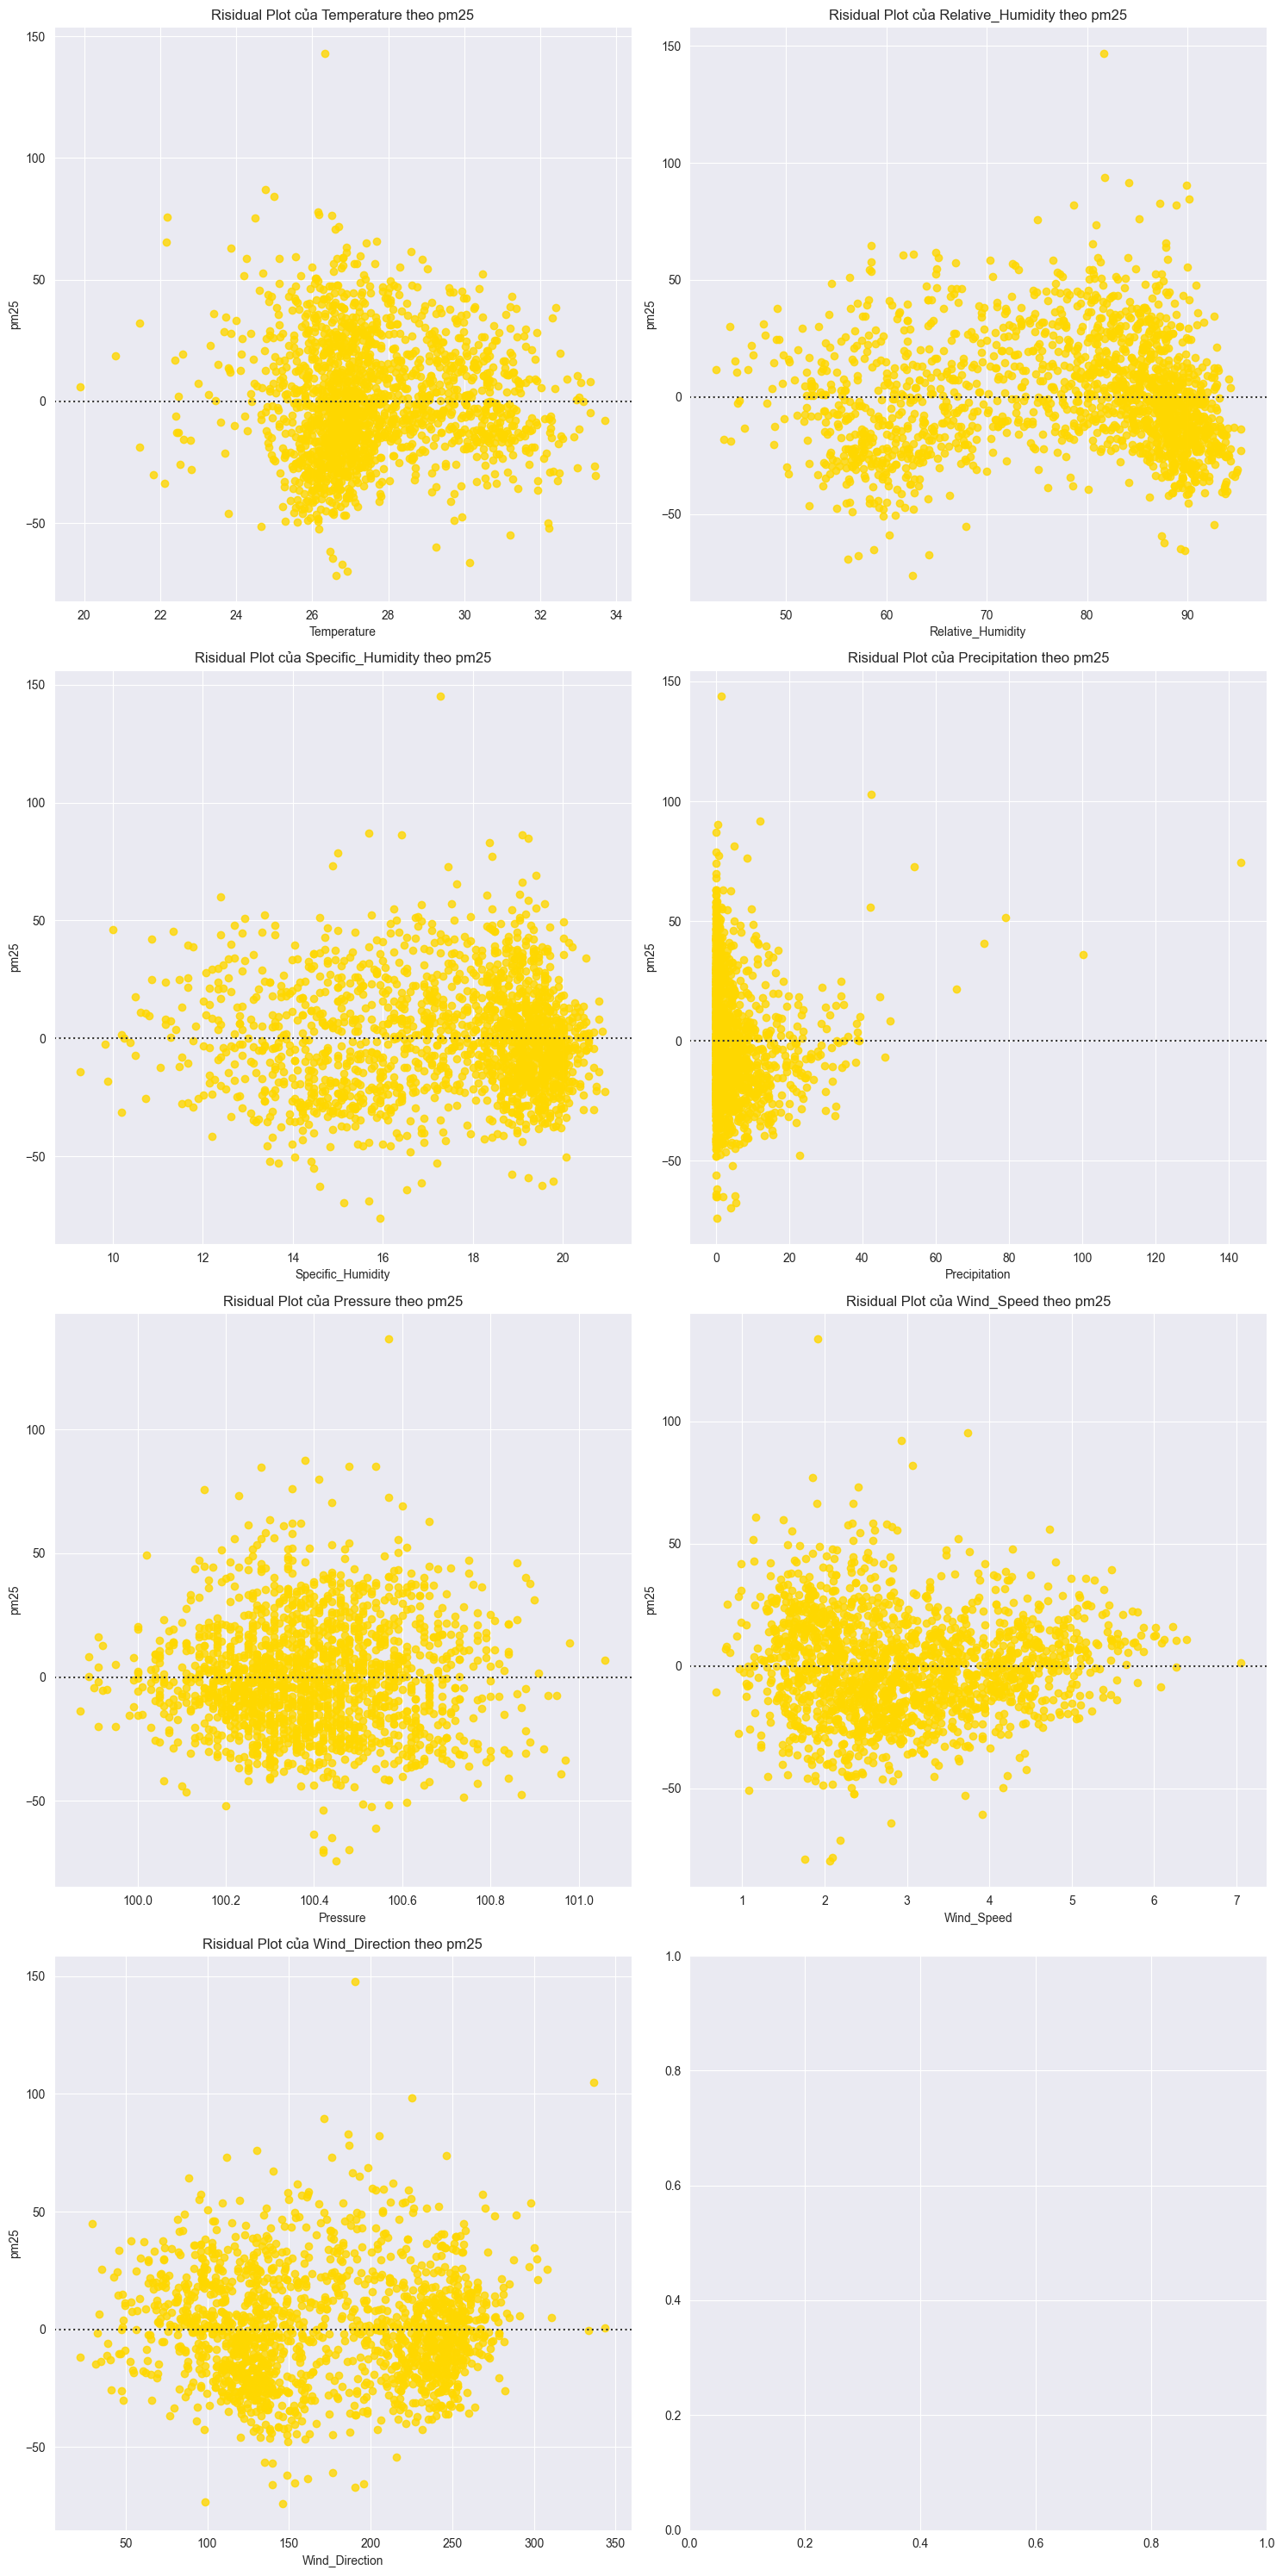

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30), sharex=False, sharey=False)
axes = axes.ravel() # Index for 1D
new_cols = cols
new_cols.remove('Temperature')

for col, ax in zip(cols, axes):
    sns.residplot(data=df, x=col, y='Temperature', color="gold", ax=ax)
    ax.set(title=f'Risidual Plot của {col} theo Temperature')
    
fig.tight_layout()
plt.show()

### 4. Time Series Plot

In [ ]:
def line_circle_plot_top_10(col, n):
    # Get indeces
    idx_top = df.sort_values(by=col, ascending=False)[:n].index

    # Sources
    source_circle = ColumnDataSource(
        pd.DataFrame(dict(
            DATE=[df.loc[i]['DATE'] for i in idx_top],
            COL=[df.loc[i][col] for i in idx_top]
        ))
    )
    source_line = ColumnDataSource(df)

    # Figure
    p = figure(
        x_axis_type='datetime',
        plot_height=700,
        plot_width=1500,
        tools='save, pan, box_zoom, wheel_zoom, reset',
    )

    # Plot
    p.line(x='DATE', y=col, source=source_line, line_color='#747C92', line_width=1)
    p.circle(
        x='DATE', 
        y='COL', 
        source=source_circle,
        #size=15
        size={
            'field': 'COL',
            'transform': LinearInterpolator(
                    x=[df[col].min(), df[col].max()],
                    y=[1, 30]
            )
        },
        color='#3A2449'
    )

    p.add_tools(
        HoverTool(
            tooltips="<b>Ngày: </b> @DATE{%F} <br> <b>Mức độ " + col + ": </b> @" + col,
            formatters={'@DATE': 'datetime'},
            mode='mouse'
        )
    )

    # Title
    p.title_location = "above"
    p.title.text_font_size = "25px"
    p.title.align = "center"
    p.title.background_fill_color = None
    p.title.text_color = "black"

    p.xaxis.axis_label = 'Ngày'
    p.yaxis.axis_label = col
    p.title.text = "Biểu đồ đột biến của " + col + " và " + str(n) + " ngày có mức độ " + col + " cao nhất"

    show(p)

__Top 10 ngày có mức độ `Temperature` cao nhất__

In [ ]:
line_circle_plot_top_10('Temperature', 10)

Figure(id='1053', ...)

__Top 10 ngày có mức độ `Relative_Humidity` cao nhất__

In [ ]:
line_circle_plot_top_10('Relative_Humidity', 10)

Figure(id='1104', ...)

__Top 10 ngày có mức độ `Specific_Humidity` cao nhất__

In [ ]:
line_circle_plot_top_10('Specific_Humidity', 10)

Figure(id='1155', ...)

__Top 10 ngày có mức độ `Precipitation` cao nhất__

In [ ]:
line_circle_plot_top_10('Precipitation', 10)

Figure(id='1206', ...)

__Top 10 ngày có mức độ `Pressure` cao nhất__

In [ ]:
line_circle_plot_top_10('Pressure', 10)

Figure(id='1257', ...)

__Top 10 ngày có mức độ `Wind_Speed` cao nhất__

In [ ]:
line_circle_plot_top_10('Wind_Speed', 10)

Figure(id='1308', ...)

__Top 10 ngày có mức độ `Wind_Direction` cao nhất__

In [ ]:
line_circle_plot_top_10('Wind_Direction', 10)

Figure(id='1359', ...)

### 6. Avg. each `Numerical var` by `Categorical var`

In [ ]:
def avg_per_category_barplot(category, col):
    df_temp = df[[category, col]]
    df_groupby = df_temp.groupby([category], as_index=False).mean()

    # Sources
    ranges = [str(x) for x in list(df_groupby[category])]
    counts = [str(x) for x in list(df_groupby[col])]

    from bokeh.io import curdoc
    curdoc().theme = "dark_minimal"
    
    # Source
    source = ColumnDataSource(data=dict(ranges=ranges, counts=counts))

    # Figure
    p = figure(
        y_range=ranges,
        width=1400,
        height=600,
        x_axis_label=col,
        y_axis_label=category,
        title="Trung bình " + col + " theo " + category,
        toolbar_location="below",
        tools='save, pan, box_zoom, wheel_zoom, reset'
    )
    p.hbar(y='ranges', right='counts', source=source, height=0.8)

    # Add tools    
    p.add_tools(
        HoverTool(
            tooltips="Năm: @ranges <br> Mức độ " + col + " trung bình: @counts",
            #formatters={'@ranges': 'int'},
            mode='mouse'
        )
    )

    p.title_location = "above"
    p.title.text_font_size = "25px"
    p.title.align = "center"
    p.title.background_fill_color = "green"
    p.title.text_color = "white"
    
    show(p)

__Avg. each `Feature` by `MO`__

In [ ]:
avg_per_category_barplot('MO', 'Temperature')

__Avg. each `Feature` by `YEAR`__

In [ ]:
avg_per_category_barplot('YEAR', 'Temperature')

### 7. Avg. each `Quarter` in each `YEAR`

In [ ]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.io import curdoc

def avg_quarter_year_barplot(col):
    df_temp = df[['YEAR', 'QUARTER', col]]
    df_groupby = df_temp.groupby(['YEAR', 'QUARTER'], as_index=False).mean()

    curdoc().theme = "dark_minimal"

    # Source
    years = [str(x) for x in list(df_groupby['YEAR'].unique())]
    quarters = [str(x) for x in list(df_groupby['QUARTER'].unique())]

    data = {
        'YEAR': years,
        '1': list(df_groupby[df_groupby['QUARTER'] == 1][col]),
        '2': list(df_groupby[df_groupby['QUARTER'] == 2][col]),
        '3': list(df_groupby[df_groupby['QUARTER'] == 3][col]),
        '4': list(df_groupby[df_groupby['QUARTER'] == 4][col]),
    }

    x = [(year, quarter) for year in years for quarter in quarters]
    counts = sum(zip(data['1'], data['2'], data['3'], data['4']), ())

    source = ColumnDataSource(data=dict(x=x, counts=counts))

    p = figure(
        x_range=FactorRange(*x),
        width=1000,
        height=400,
        x_axis_label='Quý trong năm',
        y_axis_label=col,
        title="Trung bình " + col + " theo Quý trong các Năm",
        toolbar_location="below",
        tools='save, pan, box_zoom, wheel_zoom, reset'
    )

    p.vbar(x='x', top='counts', width=0.8, source=source)

    # Add tools    
    p.add_tools(
        HoverTool(
            tooltips="Năm, Quý: @x<br>Mức độ " + col + ": @counts",
            mode='mouse'
        )
    )

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    show(p)

avg_quarter_year_barplot('Temperature')